Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

# Needed for using CRF
!pip install git+https://www.github.com/keras-team/keras-contrib.git

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

TensorFlow is already loaded. Please restart the runtime to change versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-wto83zgo
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-wto83zgo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=f9573bc5e9dcbd97a11096d409e69fdd3e8c5e1a03f58d19ea3b1c826f4e15fd
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_FILE_ID = '1LCz7TUeCPuJdMbEH2-5SyRkhqtjLpd31'
DATA_FILENAME = 'ner_medical.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id': DATA_FILE_ID})
downloaded.GetContentFile(DATA_FILENAME)

# Read the csv file in a dataframe called "data"
data = pd.read_csv(DATA_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
data = data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

NameError: ignored

In [ ]:
# Explore the input dataset
print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  3000
Number of words in the dataset:  18579
Tags: ['B-Disease', 'B-Chemical', 'I-Disease', 'O', 'I-Chemical']
Number of Labels:  5
What the dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Famotidine,B-Chemical
1,Sentence: 1,-,O
2,Sentence: 1,associated,O
3,Sentence: 1,delirium,B-Disease
4,Sentence: 1,.,O
5,Sentence: 1,A,O
6,Sentence: 1,series,O
7,Sentence: 1,of,O
8,Sentence: 1,six,O
9,Sentence: 1,cases,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of setences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences
# Example: sentence #200 
sentences[200]

[('Cocaine', 'B-Chemical'),
 ('-', 'O'),
 ('induced', 'O'),
 ('myocardial', 'B-Disease'),
 ('infarction', 'I-Disease'),
 (':', 'O'),
 ('clinical', 'O'),
 ('observations', 'O'),
 ('and', 'O'),
 ('pathogenetic', 'O'),
 ('considerations', 'O'),
 ('.', 'O')]

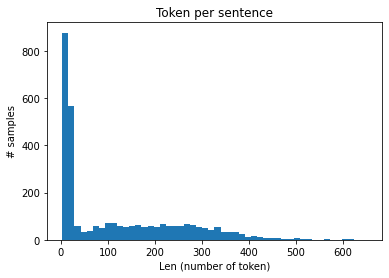

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx:

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'delirium'
print(word2idx['delirium'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Chemical'
print(tag2idx['B-Chemical'])
# Tag of index 4
print(idx2tag[4])

569
cited
1
I-Chemical


In [ ]:
# Split train and test data
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[1]] for w in s] for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = math.ceil(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2400
Points in y_train before removal: 2400
Points in X_train before removal: 1200
Points in y_train before removal: 1200


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

[16745, 4494, 9916, 1769, 10591, 16024, 12374, 8412, 9310, 10906, 4238, 12368, 11145, 3824, 8620, 2393, 10001, 5030, 9310, 17943, 12380, 3538, 2045, 3918, 3024, 2045, 14218, 3364, 2045, 17042, 12546, 10163, 17458, 16600, 13101, 15158, 11145, 11414, 18122, 5024, 4875, 15058, 12990, 7900, 15197, 5587, 14536, 10353, 9968, 2346, 11145, 16745, 9078, 9916, 9425, 5086, 6733, 5599, 16605, 15398, 1666, 6000, 8620, 2393, 16241, 15855, 14068, 9310, 17943, 12380, 3538, 8052, 5711, 11054, 10906, 4602, 16776, 3981, 5974, 3235, 11145, 3149, 8505, 15197, 8674, 10626, 15197, 13094, 15197, 5604, 15197, 10505, 12380, 13710, 15197, 15880, 15197, 14151, 4142, 12380, 17569, 15197, 12684, 3902, 10906, 4602, 16776, 5587, 6430, 10906, 727, 9916, 4875, 6757, 9916, 8412, 2943, 11145, 8550, 15197, 5226, 14151, 1851, 3902, 7643, 10906, 4602, 16776, 11145, 1394, 16024, 4426, 3307, 15855, 10858, 18025, 14403, 4875, 13315, 4225, 6716, 9916, 2346, 11145, 5087, 515, 10906, 4225, 16776, 17493, 6656, 11145]
[3, 3, 3, 3, 

In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 1.x
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

DATA_FILE_ID = '1LCz7TUeCPuJdMbEH2-5SyRkhqtjLpd31'
DATA_FILENAME = 'ner_medical.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id': DATA_FILE_ID})
downloaded.GetContentFile(DATA_FILENAME)
data = pd.read_csv(DATA_FILENAME, encoding="latin1")
data = data.fillna(method="ffill")
words = list(set(data["Word"].values))
n_words = len(words)
tags = list(set(data["Tag"].values))
n_tags = len(tags)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_test[0])
print(y_test[0])

print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_bftlzb4
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_bftlzb4
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=c7c723623be2641a13b02ffc73db9fb9266074c60c58b90a020360862dd7bad5
  Stored in directory: /tmp/pip-ephem-wheel-cache-ys0a0gq6/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ce9bd07c70409d3bb1b5146a003629e6ecd24ca41b47f70cbf63f3ac97791028
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[16745, 4494, 9916, 1769, 10591, 16024, 12374, 8412, 9310, 10906, 4238, 12368, 11145, 3824, 8620, 2393, 10001, 5030, 9310, 17943, 12380, 3538, 2045, 3918, 3024, 2045, 14218, 3364, 2045, 17042, 12546, 10163, 17458, 16600, 13101, 15158, 11145, 11414, 18122, 5024, 4875, 15058, 12990, 7900, 15197, 5587, 14536, 10353, 9968, 2346, 11145, 16745, 9078, 9916, 9425, 5086, 6733, 5599, 16605, 15398, 1666, 6000, 8620, 2393, 16241, 15855, 14068, 9310, 17943, 12380, 3538, 8052, 5711, 11054, 10906, 4602, 16776, 3981, 5974, 3235, 11145, 3149, 8505, 15197, 8674, 10626, 1

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
# Model creation function
def create_model(maxlen, n_words):
  input = Input(shape=(maxlen,))
  word_embedding_size = 150

  model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
  model = Bidirectional(CuDNNLSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           kernel_initializer=k.initializers.he_normal()))(model)
  model = CuDNNLSTM(units=word_embedding_size * 2, 
              return_sequences=True, 
              kernel_initializer=k.initializers.he_normal())(model)
  model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  
  crf = CRF(n_tags)
  out = crf(model)
  model = Model(input, out)

  adam = k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
  model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  model.summary()

  return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df):
  filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  callbacks_list = [checkpoint, early_stopping]

  history = model.fit(X_train_df, np.array(y_train_df), batch_size=100, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_y_train, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=n_words - 1)
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1)

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  model = None
  model = create_model(maxlen, n_words)

  train(model, augmented_X_train, augmented_y_train)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainab

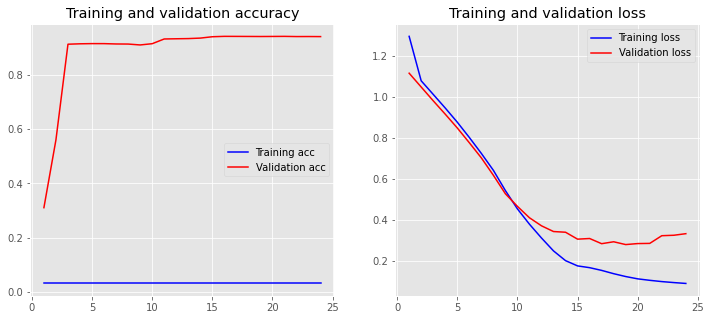

600/600 [==============================] - 5s 8ms/step
F1-score: 32.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.05555555555555555,6.549646319098769e-05,0.00013083867591259977,15268.0
Disease,0.6051598979792034,0.5019936528602815,0.5487701819152248,12289.0
micro avg,0.6041911476694085,0.2238995536524295,0.3267229738674574,27557.0
macro avg,0.3303577267673795,0.25102957466173625,0.27445051029556866,27557.0
weighted avg,0.30065073151971017,0.2238995536524295,0.24479567479987047,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

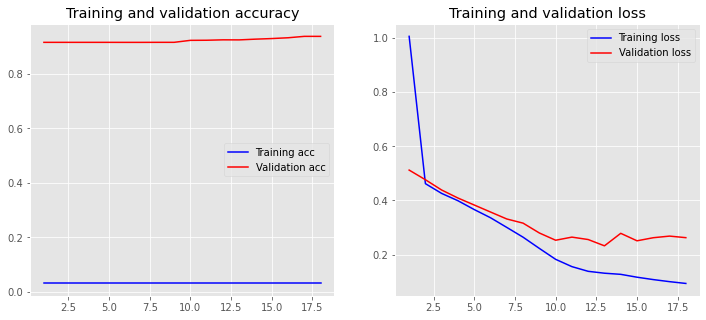

600/600 [==============================] - 5s 9ms/step
F1-score: 27.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.33804238143289606,0.021941315168980874,0.04120794636816533,15268.0
Disease,0.3540629175270254,0.47440800716087556,0.40549469657450876,12289.0
micro avg,0.35315346279429455,0.2237181115506042,0.27391478206780107,27557.0
macro avg,0.34605264947996073,0.2481746611649282,0.22335132147133704,27557.0
weighted avg,0.34518671383703137,0.2237181115506042,0.2036610389865837,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

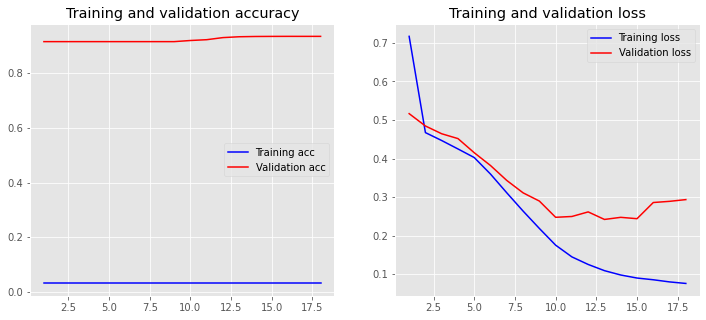

600/600 [==============================] - 5s 9ms/step
F1-score: 28.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3739130434782609,0.0028163479172124703,0.005590587011636221,15268.0
Disease,0.4570446735395189,0.454552852144194,0.4557953571865693,12289.0
micro avg,0.45626975763962063,0.20426751823493122,0.28219782423422074,27557.0
macro avg,0.4154788585088899,0.22868460003070323,0.23069297209910278,27557.0
weighted avg,0.4109854607160879,0.20426751823493122,0.20635868298288682,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

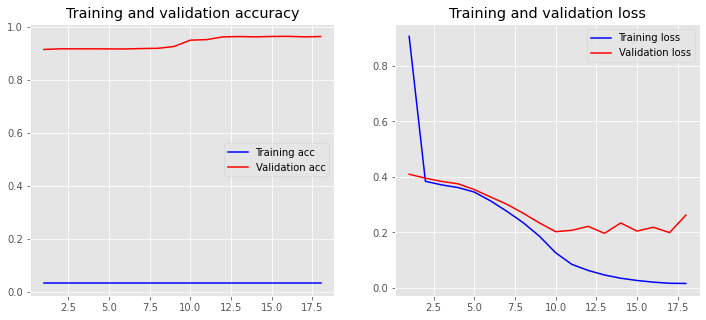

600/600 [==============================] - 5s 9ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8238260321462338,0.6848310191249672,0.747925608011445,15268.0
Disease,0.7156423388817755,0.5457726422003417,0.6192696551405753,12289.0
micro avg,0.7778734590282813,0.6228181587255507,0.6917635678442594,27557.0
macro avg,0.7697341855140047,0.6153018306626545,0.6835976315760102,27557.0
weighted avg,0.7755816874596957,0.6228181587255507,0.690551691952726,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

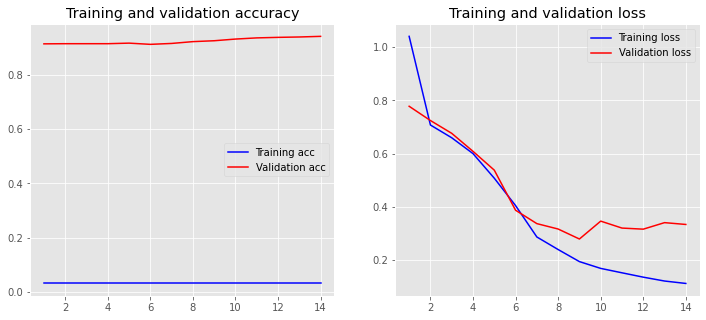

600/600 [==============================] - 6s 9ms/step
F1-score: 45.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7996176861702128,0.6301414723604926,0.7048351648351648,15268.0
Disease,0.12606721162579473,0.056473268776955,0.07800382151286951,12289.0
micro avg,0.5881849803273079,0.37431505606560944,0.4574888011708874,27557.0
macro avg,0.46284244889800374,0.3433073705687238,0.3914194931740172,27557.0
weighted avg,0.4992489311650833,0.37431505606560944,0.42530073154824366,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

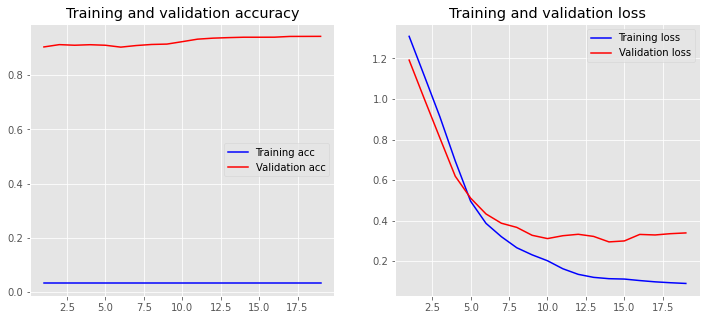

600/600 [==============================] - 6s 9ms/step
F1-score: 50.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.800571052053591,0.7162038249934504,0.7560410688975697,15268.0
Disease,0.07326236693800876,0.019041419155342177,0.03022670025188917,12289.0
micro avg,0.662730671097134,0.40530536705737197,0.5029948209862644,27557.0
macro avg,0.4369167094957999,0.3676226220743963,0.3931338845747294,27557.0
weighted avg,0.47622890917209487,0.40530536705737197,0.4323653140517314,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

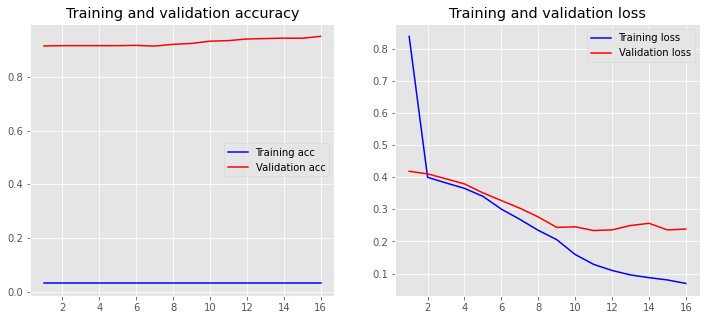

600/600 [==============================] - 6s 10ms/step
F1-score: 41.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7627038525171355,0.21135708671731726,0.3309913328888661,15268.0
Disease,0.42580563788862963,0.5494344535763691,0.47978398351453133,12289.0
micro avg,0.4967642373556352,0.3621221468229488,0.41888970511071466,27557.0
macro avg,0.5942547452028826,0.38039577014684317,0.40538765820169875,27557.0
weighted avg,0.6124646334595564,0.3621221468229488,0.39734517704965283,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

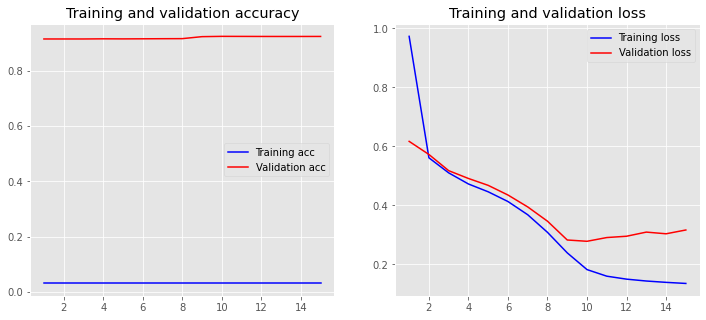

600/600 [==============================] - 6s 10ms/step
F1-score: 8.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.4722222222222222,0.0022268797484935815,0.004432855280312908,15268.0
Disease,0.24115004492362982,0.10920335259174872,0.15033045816063628,12289.0
micro avg,0.24410147241440483,0.04993286642232463,0.08290654937639332,27557.0
macro avg,0.356686133572926,0.055715116170121155,0.07738165672047459,27557.0
weighted avg,0.369175954964451,0.04993286642232463,0.06949565753731816,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

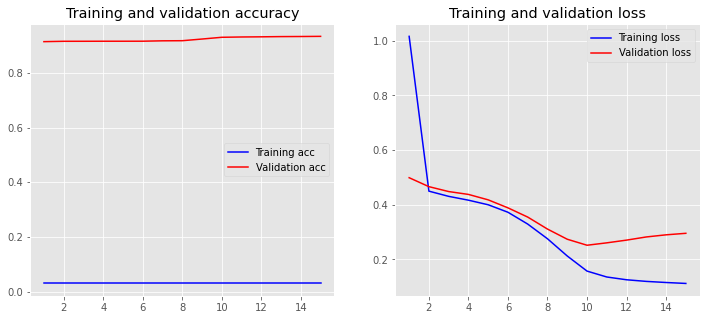

600/600 [==============================] - 6s 10ms/step
F1-score: 45.7%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.5710559208738656,0.6882368352108986,0.624194362766937,15268.0
Disease,0.0,0.0,0.0,12289.0
micro avg,0.5710559208738656,0.38131872119606636,0.4572870882109753,27557.0
macro avg,0.2855279604369328,0.3441184176054493,0.3120971813834685,27557.0
weighted avg,0.31639444786813437,0.38131872119606636,0.3458358867338822,27557.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1200
Points in y_train after augmentation: 1200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_20 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

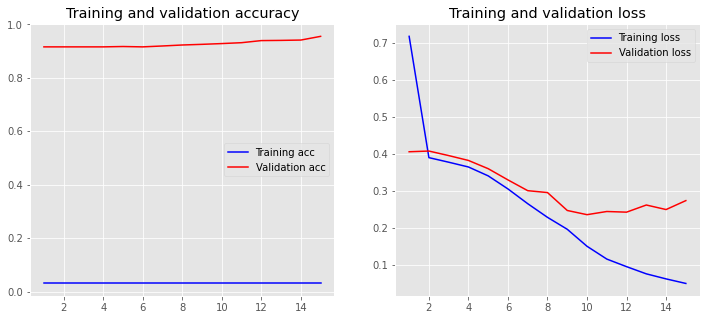

600/600 [==============================] - 6s 10ms/step
F1-score: 54.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8008544979824354,0.4419701336127849,0.5695956782307757,15268.0
Disease,0.5297164428057238,0.4910082187321995,0.5096283783783784,12289.0
micro avg,0.6450017661603673,0.4638385891062162,0.5396208890952843,27557.0
macro avg,0.6652854703940796,0.4664891761724922,0.5396120283045771,27557.0
weighted avg,0.6799409166758124,0.4638385891062162,0.5428533569372347,27557.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_11 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

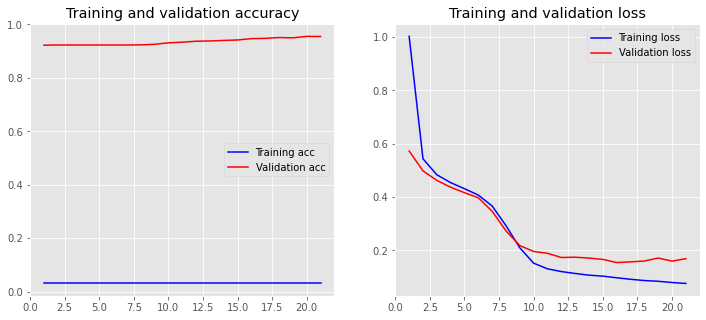

600/600 [==============================] - 6s 11ms/step
F1-score: 50.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8125,0.3967775740110034,0.5331807780320367,15268.0
Disease,0.42612303806602925,0.5766132313451053,0.4900753855729995,12289.0
micro avg,0.5457338592484949,0.47697499727836845,0.5090430269935323,27557.0
macro avg,0.6193115190330146,0.48669540267805433,0.5116280818025181,27557.0
weighted avg,0.6401958128531202,0.47697499727836845,0.5139579973255335,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_24 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_12 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

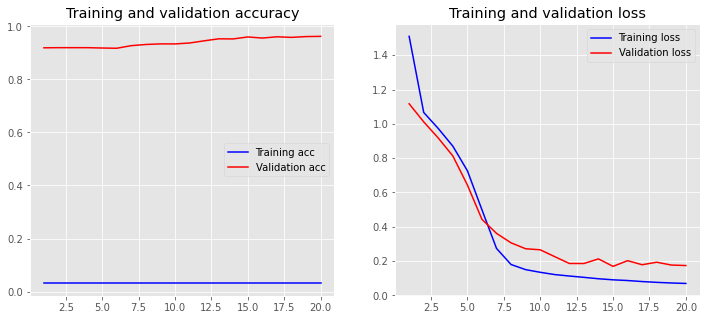

600/600 [==============================] - 6s 11ms/step
F1-score: 60.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8872349272349273,0.6987817657846477,0.781812186274869,15268.0
Disease,0.39105607596561015,0.49597200748636994,0.4373094170403587,12289.0
micro avg,0.6071493245445656,0.6083390789998911,0.6077436194895592,27557.0
macro avg,0.6391455016002687,0.5973768866355088,0.6095608016576138,27557.0
weighted avg,0.6659647634562634,0.6083390789998911,0.6281817282742559,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_26 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_13 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

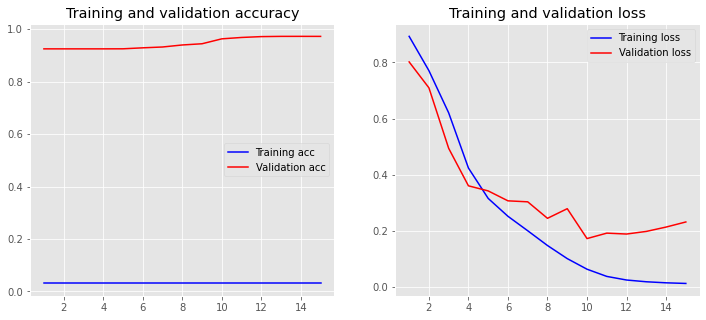

600/600 [==============================] - 7s 11ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8401150251617542,0.7653916688498821,0.8010144629515389,15268.0
Disease,0.718397594243368,0.5443079176499308,0.6193518518518518,12289.0
micro avg,0.791309590456914,0.6667997242080053,0.7237386269644334,27557.0
macro avg,0.7792563097025611,0.6548497932499064,0.7101831574016954,27557.0
weighted avg,0.785835331851305,0.6667997242080053,0.7200023125794355,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_28 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_14 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

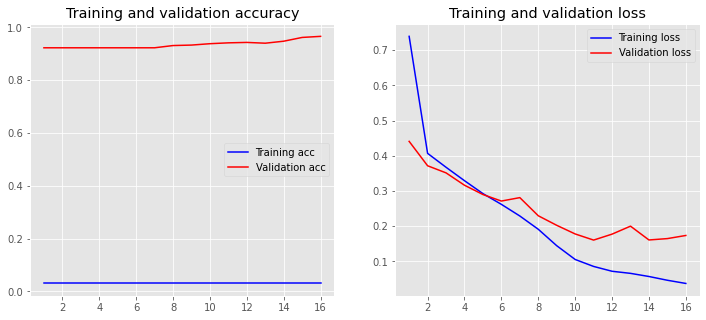

600/600 [==============================] - 7s 11ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9145482388973967,0.5867173172648676,0.7148386067110881,15268.0
Disease,0.7826804577464789,0.5788103181707218,0.6654815923656267,12289.0
micro avg,0.8510829846952285,0.5831912036869035,0.6921188630490955,27557.0
macro avg,0.8486143483219377,0.5827638177177947,0.6901600995383574,27557.0
weighted avg,0.8557420131629687,0.5831912036869035,0.6928279252402685,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_15 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

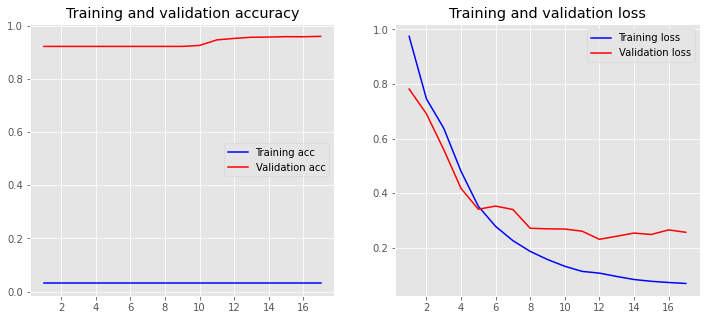

600/600 [==============================] - 7s 12ms/step
F1-score: 65.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8424256258084152,0.7251768404506157,0.77941642321636,15268.0
Disease,0.5667175572519084,0.4530881275937831,0.5035723975761961,12289.0
micro avg,0.724486241727621,0.6038393148746235,0.658683819891143,27557.0
macro avg,0.7045715915301618,0.5891324840221994,0.6414944103962781,27557.0
weighted avg,0.7194740543568453,0.6038393148746235,0.6564042219211546,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_32 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_16 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

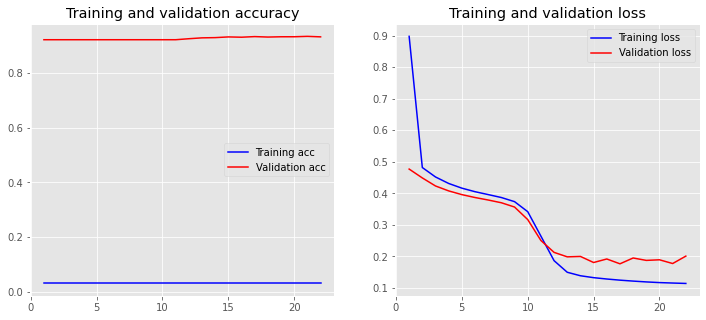

600/600 [==============================] - 7s 12ms/step
F1-score: 23.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.723404255319149,0.0022268797484935815,0.0044400914136467524,15268.0
Disease,0.2890091415361984,0.447636097322809,0.3512434951952239,12289.0
micro avg,0.2900791363136104,0.20085640672061544,0.2373600926283288,27557.0
macro avg,0.5062066984276736,0.22493148853565129,0.17784179330443534,27557.0
weighted avg,0.5296864502867187,0.20085640672061544,0.1590965137046001,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_34 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_17 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

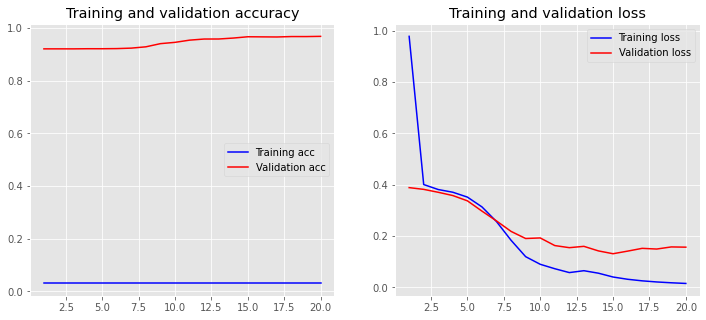

600/600 [==============================] - 7s 12ms/step
F1-score: 69.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7249496981891348,0.7079512706313859,0.7163496586917621,15268.0
Disease,0.7584185848252344,0.5791358125152576,0.6567618696073455,12289.0
micro avg,0.7378776652671442,0.6505062234640926,0.6914427879886598,27557.0
macro avg,0.7416841415071846,0.6435435415733217,0.6865557641495539,27557.0
weighted avg,0.7398750945628703,0.6505062234640926,0.6897765796171751,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_36 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_18 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

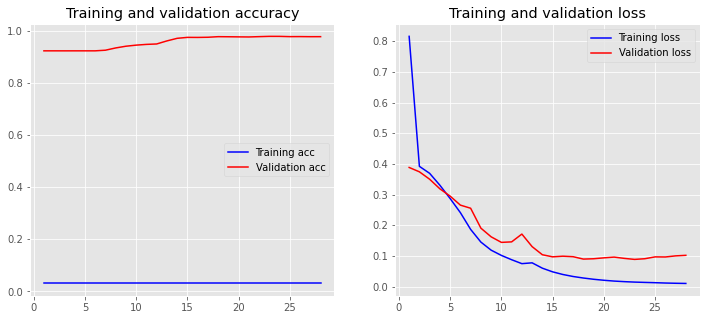

600/600 [==============================] - 7s 12ms/step
F1-score: 76.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9100525131282821,0.7945375949698716,0.8483810056647318,15268.0
Disease,0.7175459395376408,0.5910163560908129,0.648163848110303,12289.0
micro avg,0.8269657172096196,0.7037776245600029,0.7604148287557098,27557.0
macro avg,0.8137992263329614,0.6927769755303423,0.7482724268875174,27557.0
weighted avg,0.824204515056816,0.7037776245600029,0.7590944850280016,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_38 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_19 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

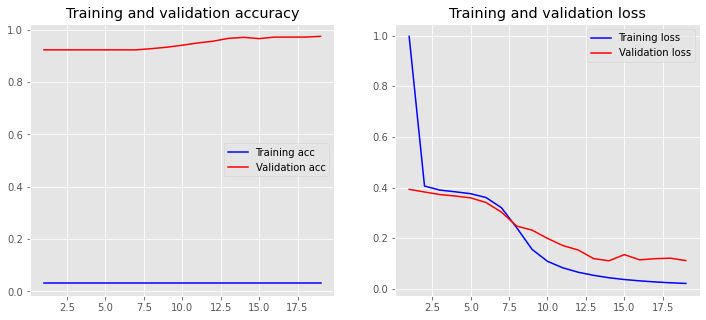

600/600 [==============================] - 8s 13ms/step
F1-score: 76.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8936423054070113,0.7880534451139638,0.8375330641793123,15268.0
Disease,0.7520710649765445,0.6131499715192449,0.675542406311637,12289.0
micro avg,0.8332410680066431,0.7100555212831585,0.7667319749216301,27557.0
macro avg,0.8228566851917779,0.7006017083166043,0.7565377352454746,27557.0
weighted avg,0.8305088375531082,0.7100555212831585,0.7652935898339241,27557.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_40 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_20 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

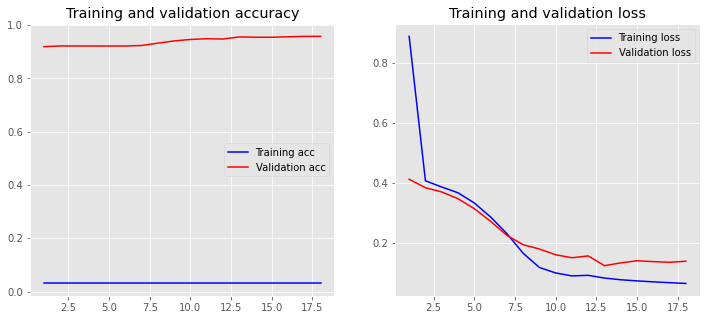

600/600 [==============================] - 8s 13ms/step
F1-score: 57.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6360486192557842,0.7814383023316741,0.7012872509257626,15268.0
Disease,0.500942587832048,0.23785499226950932,0.32255572721253584,12289.0
micro avg,0.6039930061399585,0.5390281961026236,0.5696644295302012,27557.0
macro avg,0.5684956035439162,0.5096466473005917,0.5119214890691492,27557.0
weighted avg,0.575798301000303,0.5390281961026236,0.5323925347044088,27557.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_42 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_21 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

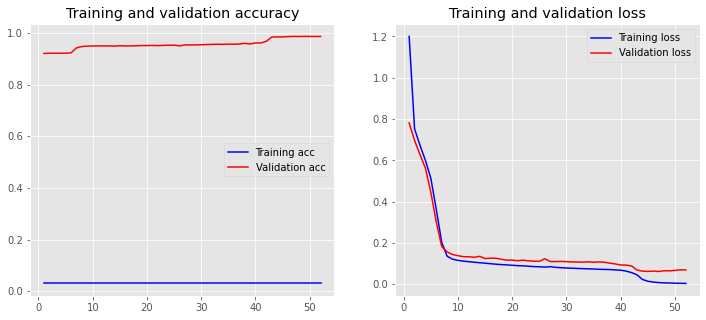

600/600 [==============================] - 8s 13ms/step
F1-score: 61.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9035415111553454,0.7135184700026198,0.7973650503202194,15268.0
Disease,0.4014336917562724,0.4556920823500692,0.4268455352719235,12289.0
micro avg,0.6342138654977506,0.5985412055013245,0.61586139944739,27557.0
macro avg,0.652487601455809,0.5846052761763445,0.6121052927960715,27557.0
weighted avg,0.679627333538217,0.5985412055013245,0.6321324662062554,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_44 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_22 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

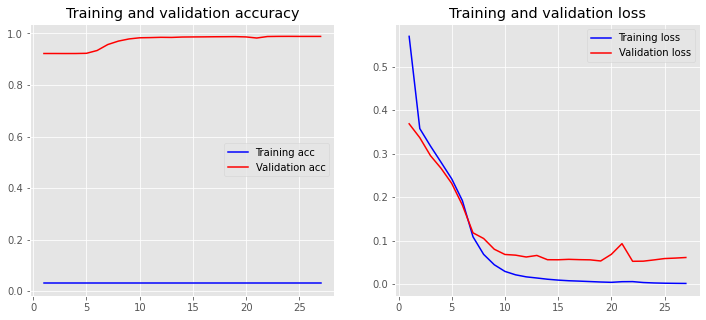

600/600 [==============================] - 8s 14ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8885152805798401,0.7788184438040345,0.8300582876688423,15268.0
Disease,0.613697705802969,0.5920742127105542,0.6026920687512942,12289.0
micro avg,0.7594199453227148,0.6955401531371339,0.7260777331616031,27557.0
macro avg,0.7511064931914045,0.6854463282572943,0.7163751782100682,27557.0
weighted avg,0.7659608234026085,0.6955401531371339,0.7286646866136568,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_46 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_23 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

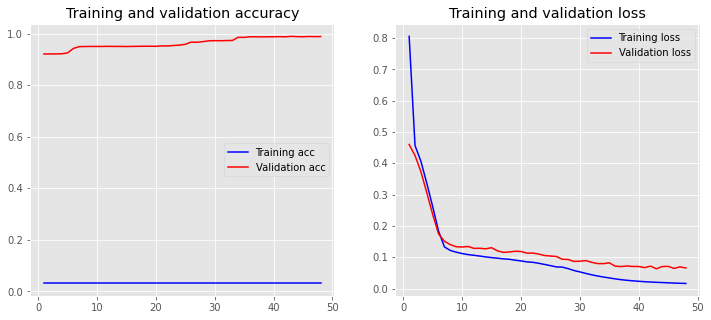

600/600 [==============================] - 8s 14ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8725376593279258,0.7891013885250197,0.8287247214197276,15268.0
Disease,0.6611587533988705,0.5144438115387745,0.5786462862111573,12289.0
micro avg,0.7860504920838682,0.6666182821061799,0.7214247844954543,27557.0
macro avg,0.7668482063633981,0.6517726000318971,0.7036855038154425,27557.0
weighted avg,0.7782735748861448,0.6666182821061799,0.7172026438975692,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_48 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_24 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

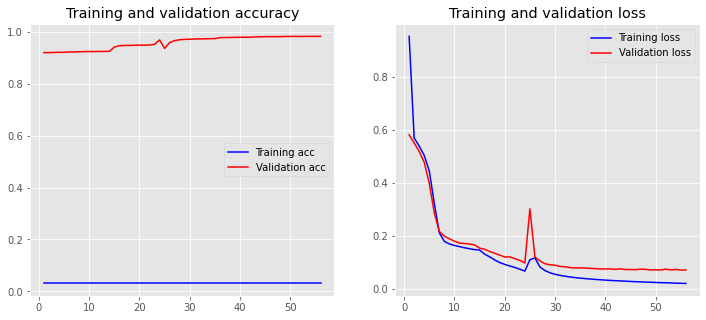

600/600 [==============================] - 9s 14ms/step
F1-score: 68.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8889788706471324,0.7908697930311763,0.8370593740251638,15268.0
Disease,0.5212351872675374,0.490357230043128,0.5053249475890985,12289.0
micro avg,0.7198934139357301,0.6568566970279783,0.6869319367753933,27557.0
macro avg,0.7051070289573349,0.6406135115371522,0.6711921608071312,27557.0
weighted avg,0.7249841642185719,0.6568566970279783,0.6891229380389241,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_50 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_25 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

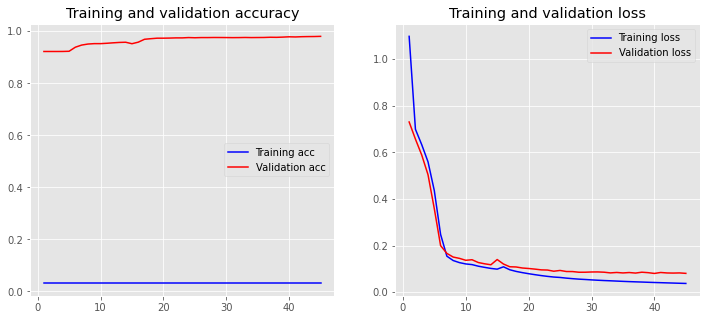

600/600 [==============================] - 9s 14ms/step
F1-score: 57.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8536098923015556,0.7008121561435683,0.7697011113908571,15268.0
Disease,0.33229257010696733,0.46765399951175846,0.3885208220659816,12289.0
micro avg,0.55135769359705,0.5968356497441666,0.5731960200045306,27557.0
macro avg,0.5929512312042615,0.5842330778276634,0.5791109667284193,27557.0
weighted avg,0.62112926768896,0.5968356497441666,0.5997143720682386,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_52 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_26 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

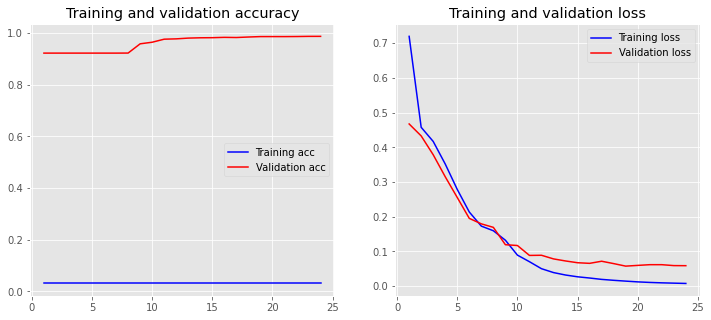

600/600 [==============================] - 9s 14ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8892405063291139,0.7361802462667016,0.8055037981940661,15268.0
Disease,0.5332258516753119,0.6190088697208886,0.5729241197514592,12289.0
micro avg,0.7004757303203747,0.6839278586203142,0.6921028955437637,27557.0
macro avg,0.7112331790022128,0.6775945579937952,0.6892139589727626,27557.0
weighted avg,0.7304763414693479,0.6839278586203142,0.70178526321634,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_54 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_27 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

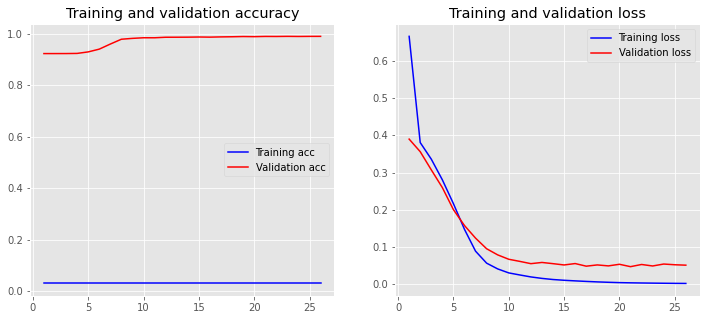

600/600 [==============================] - 9s 15ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8818129246783287,0.7989913544668588,0.8383616246306095,15268.0
Disease,0.6307107694965023,0.5942712995361705,0.6119490531255237,12289.0
micro avg,0.7674025105261086,0.7076967739594295,0.7363413252784594,27557.0
macro avg,0.7562618470874155,0.6966313270015146,0.7251553388780666,27557.0
weighted avg,0.7698343208742331,0.7076967739594295,0.7373933011111407,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_56 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_28 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

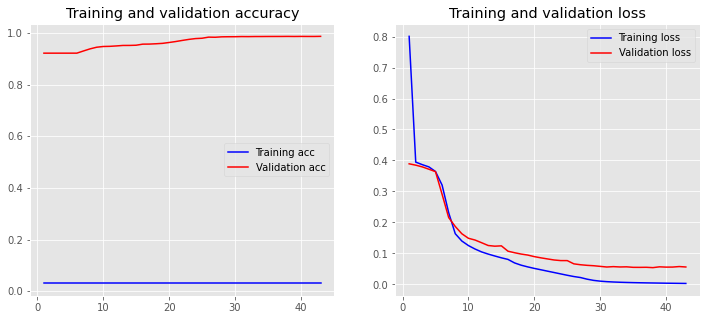

600/600 [==============================] - 9s 15ms/step
F1-score: 69.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8812006892173755,0.6364291328268273,0.7390758699372505,15268.0
Disease,0.6476671078755791,0.6370738058426235,0.6423267834434098,12289.0
micro avg,0.7590741942461605,0.6367166237253692,0.692532365014209,27557.0
macro avg,0.7644338985464774,0.6367514693347254,0.6907013266903301,27557.0
weighted avg,0.777056762770036,0.6367166237253692,0.6959307698202998,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_58 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_29 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

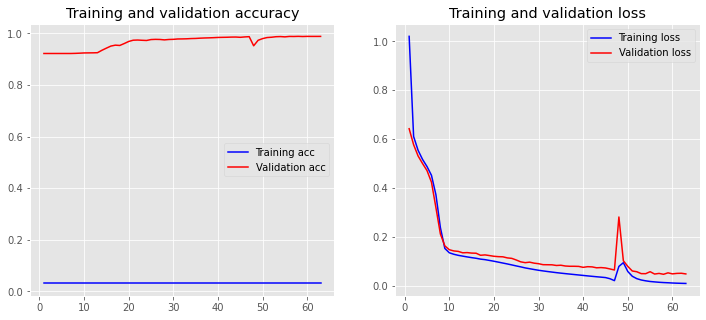

600/600 [==============================] - 9s 15ms/step
F1-score: 76.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8626308027249104,0.8044930573749017,0.8325482088995831,15268.0
Disease,0.6857681587145433,0.6806900480104158,0.6832196675787152,12289.0
micro avg,0.7810265915194614,0.7492833036977901,0.7648257213764493,27557.0
macro avg,0.7741994807197269,0.7425915526926588,0.7578839382391491,27557.0
weighted avg,0.7837591899861,0.7492833036977901,0.7659553851418394,27557.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1800
Points in y_train after augmentation: 1800


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_60 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_30 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

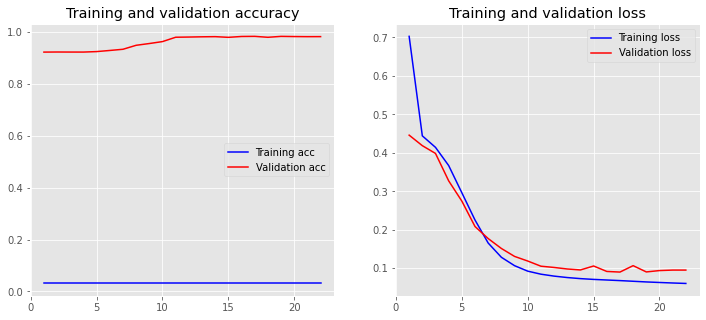

600/600 [==============================] - 9s 16ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8423460898502496,0.7957820277705004,0.8184022632358885,15268.0
Disease,0.6068713309594842,0.5131418341606314,0.5560846560846561,12289.0
micro avg,0.7437437034051985,0.6697390862575752,0.7048040937905752,27557.0
macro avg,0.7246087104048669,0.6544619309655659,0.6872434596602723,27557.0
weighted avg,0.7373364983849735,0.6697390862575752,0.7014221465946905,27557.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_62 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_31 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

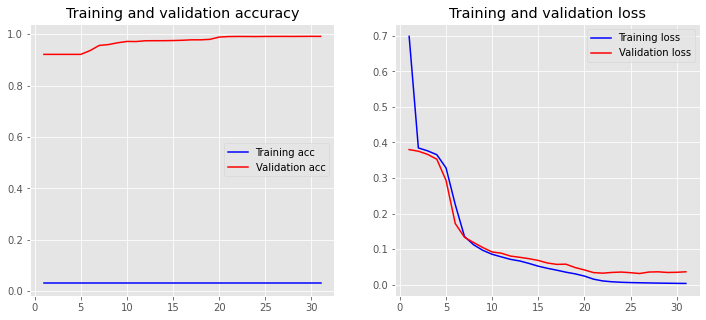

600/600 [==============================] - 10s 16ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9014191973142073,0.7737752161383286,0.832734193275534,15268.0
Disease,0.6607542775239631,0.6002115713239482,0.6290295070782876,12289.0
micro avg,0.7907206724628126,0.6963747868055303,0.7405549338170031,27557.0
macro avg,0.7810867374190852,0.6869933937311383,0.7308818501769108,27557.0
weighted avg,0.7940950619111405,0.6963747868055303,0.7418924148280266,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_64 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_32 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

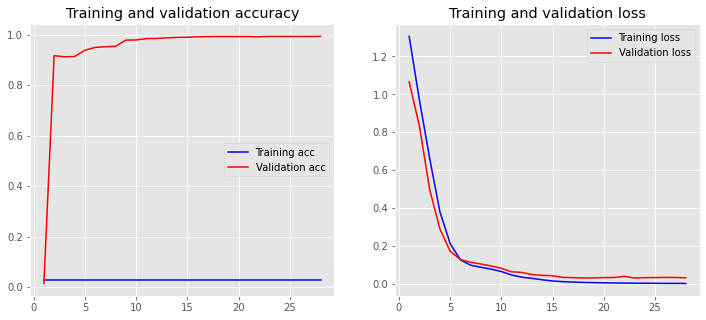

600/600 [==============================] - 10s 16ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9073779615201145,0.7475111343987425,0.8197227608992315,15268.0
Disease,0.511914774320157,0.5943526731223046,0.5500621305117295,12289.0
micro avg,0.6971988378156895,0.6792103639728563,0.6880870540227562,27557.0
macro avg,0.7096463679201357,0.6709319037605235,0.6848924457054805,27557.0
weighted avg,0.7310217867732162,0.6792103639728563,0.6994680348103244,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_66 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_33 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_33 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

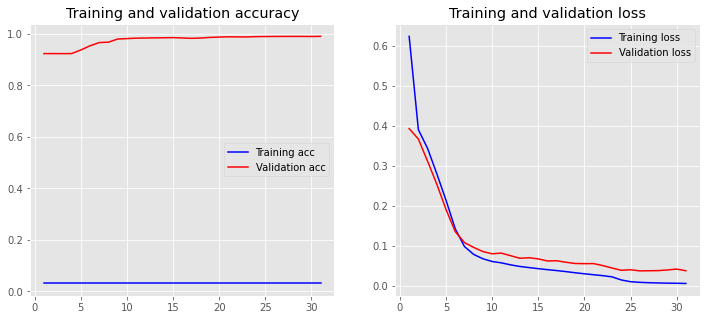

600/600 [==============================] - 10s 17ms/step
F1-score: 74.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8560413129598189,0.792572701074142,0.8230852945177527,15268.0
Disease,0.6524983232729712,0.6333306208804622,0.6427716067225503,12289.0
micro avg,0.7628913443830571,0.7215589505388831,0.7416497267861472,27557.0
macro avg,0.754269818116395,0.7129516609773021,0.7329284506201514,27557.0
weighted avg,0.7652716428120643,0.7215589505388831,0.7426746943321286,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_68 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_34 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_34 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

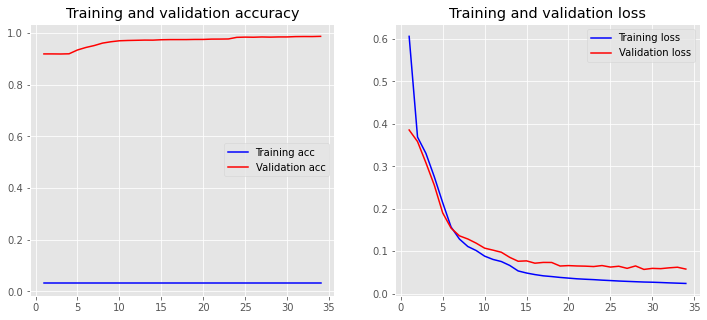

600/600 [==============================] - 10s 17ms/step
F1-score: 68.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8138365670584903,0.7527508514540214,0.7821027560394691,15268.0
Disease,0.5631708674564682,0.5763691105867036,0.5696935574680286,12289.0
micro avg,0.6957563953706132,0.6740936967013826,0.6847537599528164,27557.0
macro avg,0.6885037172574793,0.6645599810203625,0.6758981567537489,27557.0
weighted avg,0.702052599920948,0.6740936967013826,0.687379214244483,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_35 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_70 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_35 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_35 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

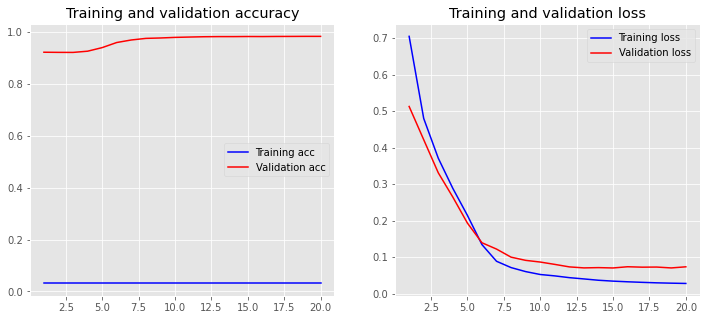

600/600 [==============================] - 10s 17ms/step
F1-score: 64.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6920991235260735,0.7188891799842808,0.7052398239470556,15268.0
Disease,0.6336142786316311,0.5199772153958825,0.5711987127916331,12289.0
micro avg,0.6693647856922602,0.6301847080596582,0.6491841273994879,27557.0
macro avg,0.6628567010788523,0.6194331976900816,0.6382192683693444,27557.0
weighted avg,0.6660179006459414,0.6301847080596582,0.6454644051790843,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_72 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_36 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_36 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

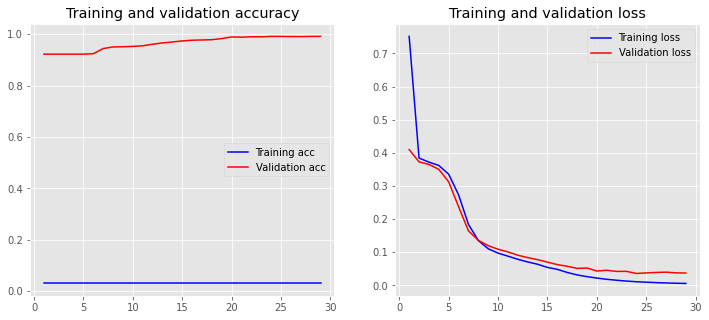

600/600 [==============================] - 11s 18ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8858544442817397,0.79244170814776,0.8365484339348683,15268.0
Disease,0.6363471807403385,0.5721376841077386,0.6025366355300368,12289.0
micro avg,0.7742744971060833,0.6941974815836267,0.7320526557477423,27557.0
macro avg,0.761100812511039,0.6822896961277494,0.7195425347324526,27557.0
weighted avg,0.7745870798494618,0.6941974815836267,0.732191247354436,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_74 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_37 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_37 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

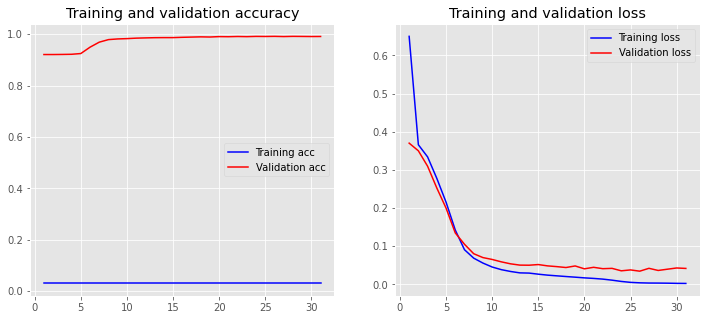

600/600 [==============================] - 11s 18ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8867966991747936,0.7742336913806654,0.8267011679138402,15268.0
Disease,0.6152470187393526,0.5877614126454553,0.6011902284739273,12289.0
micro avg,0.7596330275229358,0.6910766774322313,0.72373496494195,27557.0
macro avg,0.7510218589570732,0.6809975520130604,0.7139456981938838,27557.0
weighted avg,0.7656995542435191,0.6910766774322313,0.7261349257693002,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_38 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_76 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_38 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_38 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

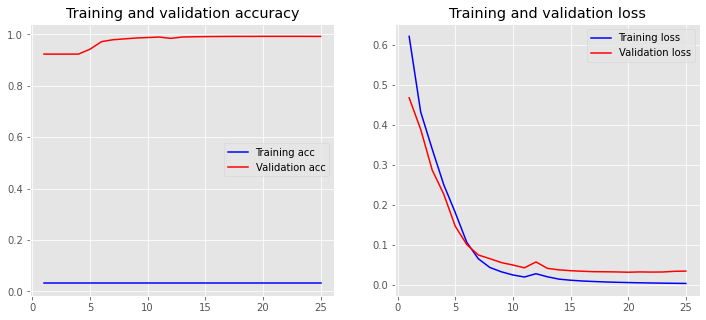

600/600 [==============================] - 11s 18ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8707718327183271,0.7418784385643176,0.8011741406139482,15268.0
Disease,0.6779910096818811,0.6382130360484987,0.6575009431194199,12289.0
micro avg,0.780029296875,0.6956490183982291,0.7354266971016439,27557.0
macro avg,0.7743814212001041,0.6900457373064082,0.7293375418666841,27557.0
weighted avg,0.7848015335458887,0.6956490183982291,0.7371033083749433,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_39 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_78 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_39 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_39 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

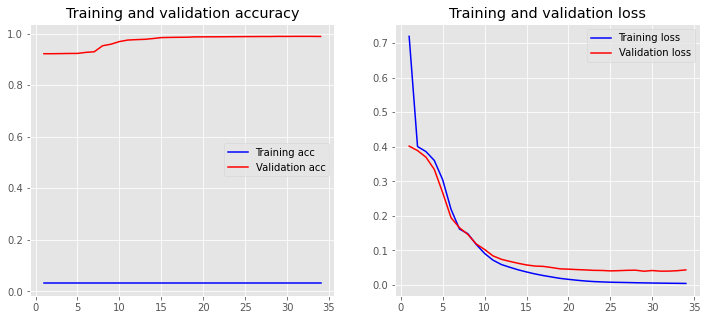

600/600 [==============================] - 11s 18ms/step
F1-score: 67.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9300743058271412,0.7788184438040345,0.8477524685416888,15268.0
Disease,0.4523775216138329,0.510944747335015,0.4798807749627422,12289.0
micro avg,0.6814175885992875,0.6593605980331676,0.6702076647855114,27557.0
macro avg,0.691225913720487,0.6448815955695248,0.6638166217522155,27557.0
weighted avg,0.7170461902413611,0.6593605980331676,0.6837006761698169,27557.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2100
Points in y_train after augmentation: 2100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_80 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_40 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_40 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

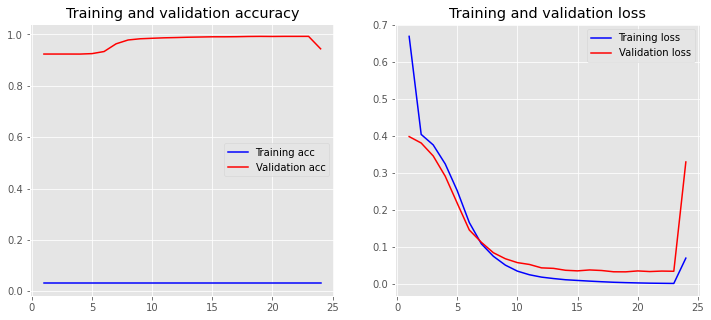

600/600 [==============================] - 11s 19ms/step
F1-score: 28.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.979539641943734,0.025085145402148283,0.04891755539945079,15268.0
Disease,0.5617699115044248,0.38741964358369274,0.45858216143324987,12289.0
micro avg,0.5801939995488382,0.1866676343578764,0.2824588858688191,27557.0
macro avg,0.7706547767240794,0.20625239449292052,0.25374985841635034,27557.0
weighted avg,0.7932358999773127,0.1866676343578764,0.23160683012272823,27557.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_82 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_41 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_41 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

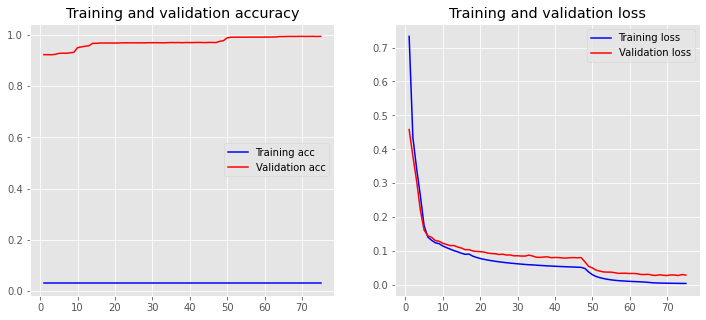

600/600 [==============================] - 12s 19ms/step
F1-score: 69.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8734726924775504,0.7772465286874509,0.8225549317252374,15268.0
Disease,0.5549132947976878,0.49995931320693304,0.5260048799280852,12289.0
micro avg,0.73043231405629,0.6535907391951228,0.6898783874365604,27557.0
macro avg,0.7141929936376191,0.638602920947192,0.6742799058266613,27557.0
weighted avg,0.7314116394569811,0.6535907391951228,0.6903089112391466,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_84 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_42 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_42 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

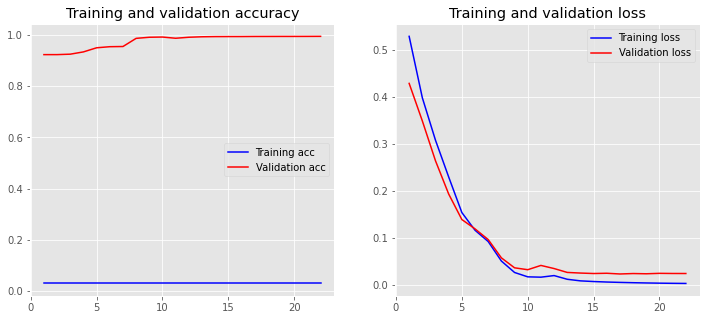

600/600 [==============================] - 12s 19ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8514564587463779,0.7313335079905685,0.7868367275033472,15268.0
Disease,0.59375,0.643176824802669,0.6174758798484434,12289.0
micro avg,0.7216377809732839,0.692020176361723,0.7065187188559361,27557.0
macro avg,0.722603229373189,0.6872551663966188,0.7021563036758953,27557.0
weighted avg,0.7365326763486482,0.692020176361723,0.7113105288303744,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_43 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_86 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_43 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_43 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

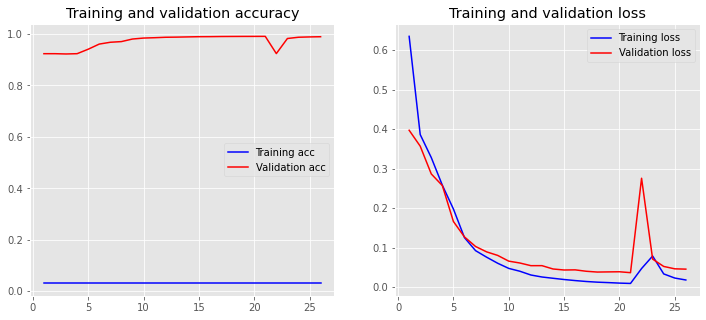

600/600 [==============================] - 12s 20ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8117746957260119,0.7513754257270108,0.7804081632653063,15268.0
Disease,0.662533215234721,0.6086744242818781,0.6344628695025234,12289.0
micro avg,0.7454960270631736,0.6877381427586458,0.715453292814134,27557.0
macro avg,0.7371539554803664,0.6800249250044444,0.7074355163839148,27557.0
weighted avg,0.7452206966057349,0.6877381427586458,0.7153240933356754,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_44 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_88 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_44 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_44 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

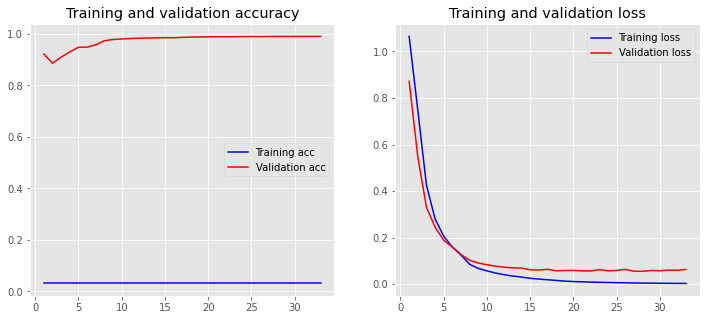

600/600 [==============================] - 12s 20ms/step
F1-score: 51.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.47856685860524634,0.5389048991354467,0.5069467976956964,15268.0
Disease,0.5604096800507569,0.5031328830661568,0.5302289683560588,12289.0
micro avg,0.5105576418904556,0.5229524258809014,0.5166807091766308,27557.0
macro avg,0.5194882693280016,0.5210188911008018,0.5185878830258777,27557.0
weighted avg,0.5150645337057246,0.5229524258809014,0.5173294444005334,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_90 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_45 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_45 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

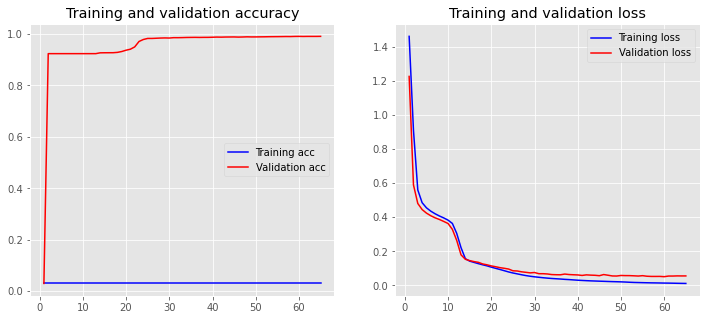

600/600 [==============================] - 12s 20ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9055741699664941,0.7788839402672255,0.8374647887323943,15268.0
Disease,0.5639009044435705,0.5834486125803564,0.5735082386818109,12289.0
micro avg,0.7374937130034434,0.6917298689988025,0.7138791101790128,27557.0
macro avg,0.7347375372050323,0.6811662764237909,0.7054865137071026,27557.0
weighted avg,0.7532055246128196,0.6917298689988025,0.7197537881310364,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_46 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_92 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_46 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_46 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

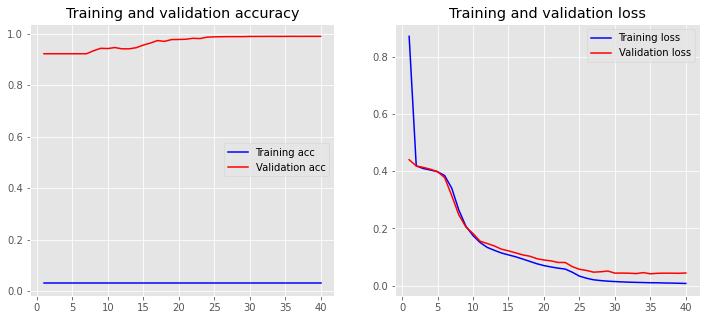

600/600 [==============================] - 12s 20ms/step
F1-score: 72.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7958555601148953,0.7621823421535238,0.7786550685848109,15268.0
Disease,0.6510072522159549,0.6574172023761087,0.6541965261751488,12289.0
micro avg,0.7293577981651376,0.7154624959175527,0.7223433292421552,27557.0
macro avg,0.7234314061654251,0.7097997722648162,0.7164257973799799,27557.0
weighted avg,0.7312606892737269,0.7154624959175527,0.7231529809964545,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_47 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_94 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_47 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_47 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

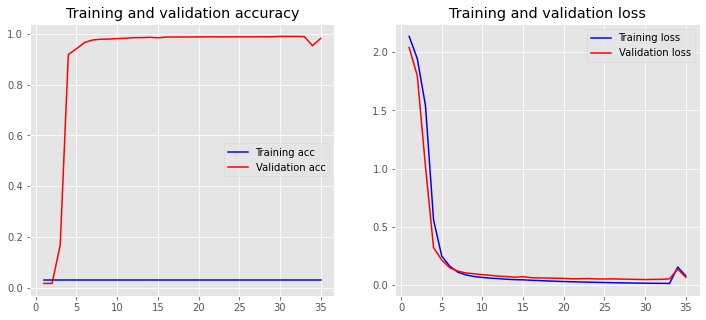

600/600 [==============================] - 12s 21ms/step
F1-score: 75.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8734205607476635,0.7651296829971181,0.8156966798170583,15268.0
Disease,0.6874682041716127,0.659777036373993,0.6733380392808205,12289.0
micro avg,0.786284715324407,0.7181478390245672,0.7506732921139476,27557.0
macro avg,0.7804443824596381,0.7124533596855556,0.7445173595489394,27557.0
weighted avg,0.7904954052531217,0.7181478390245672,0.7522120721475068,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_48 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_96 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_48 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_48 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

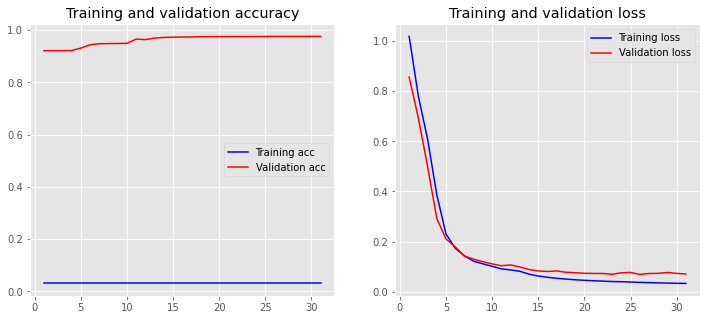

600/600 [==============================] - 12s 21ms/step
F1-score: 58.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6573135071237479,0.6919701336127849,0.6741967390957532,15268.0
Disease,0.5032655689448993,0.4451948897387908,0.47245250431778935,12289.0
micro avg,0.5951603325415677,0.5819211089741264,0.5884662666740061,27557.0
macro avg,0.5802895380343236,0.5685825116757879,0.5733246217067712,27557.0
weighted avg,0.5886160758982927,0.5819211089741264,0.5842292208177695,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_49 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_98 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_49 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_49 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

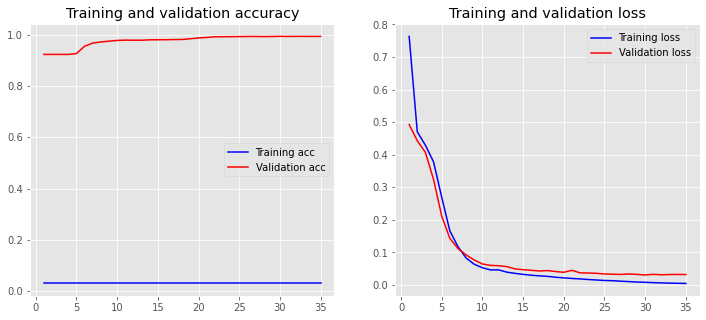

600/600 [==============================] - 13s 21ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9391682704376203,0.7351323028556458,0.8247180278481943,15268.0
Disease,0.6017564600574228,0.579868174790463,0.5906095893249348,12289.0
micro avg,0.7712352372546547,0.6658925136988787,0.7147030185004868,27557.0
macro avg,0.7704623652475215,0.6575002388230544,0.7076638085865645,27557.0
weighted avg,0.7887000141774233,0.6658925136988787,0.7203177447617793,27557.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2400
Points in y_train after augmentation: 2400


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_100 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_50 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_50 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

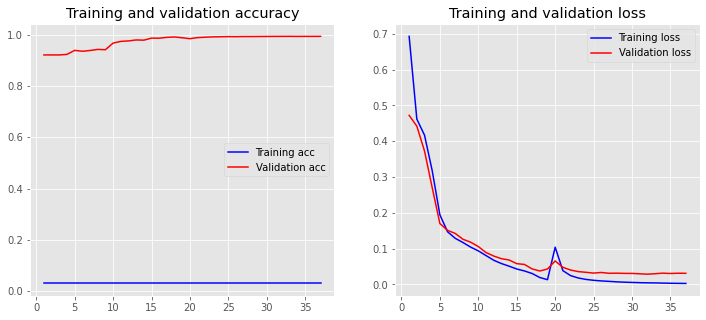

600/600 [==============================] - 13s 22ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8860072376357057,0.7697144354204873,0.8237768120005607,15268.0
Disease,0.5349401623566825,0.5201399625681504,0.5274362571169239,12289.0
micro avg,0.7196287629397533,0.658417099103676,0.6876634451392837,27557.0
macro avg,0.710473699996194,0.6449271989943188,0.6756065345587423,27557.0
weighted avg,0.7294494378714383,0.658417099103676,0.6916242163274101,27557.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_51 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_102 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_51 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_51 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

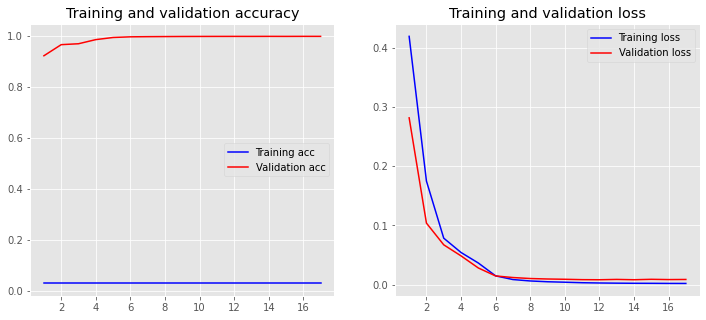

600/600 [==============================] - 13s 22ms/step
F1-score: 67.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8682056198834722,0.771024364684307,0.8167343115828911,15268.0
Disease,0.5121793315529659,0.5150134266417121,0.5135924693662257,12289.0
micro avg,0.6984488346967125,0.6568566970279783,0.6770145680997887,27557.0
macro avg,0.6901924757182191,0.6430188956630096,0.6651633904745584,27557.0
weighted avg,0.7094362670042187,0.6568566970279783,0.6815486927201483,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_52 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_104 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_52 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_52 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

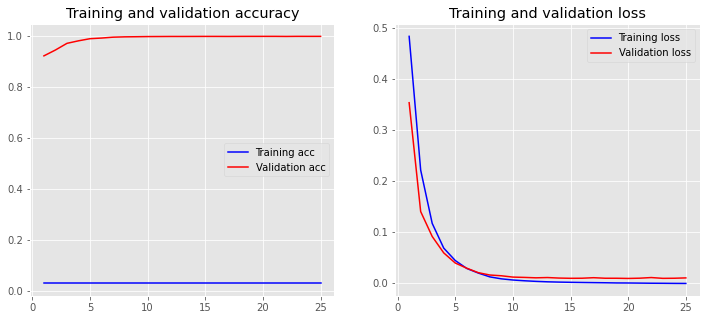

600/600 [==============================] - 13s 22ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8750651477924205,0.7697799318836783,0.819052928673473,15268.0
Disease,0.5336953287711991,0.5838554805110261,0.5576497104884778,12289.0
micro avg,0.7042976744186047,0.6868672206698843,0.6954732510288066,27557.0
macro avg,0.7043802382818098,0.6768177061973522,0.6883513195809754,27557.0
weighted avg,0.7228318239200182,0.6868672206698843,0.7024805823267951,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_53 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_106 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_53 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_53 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

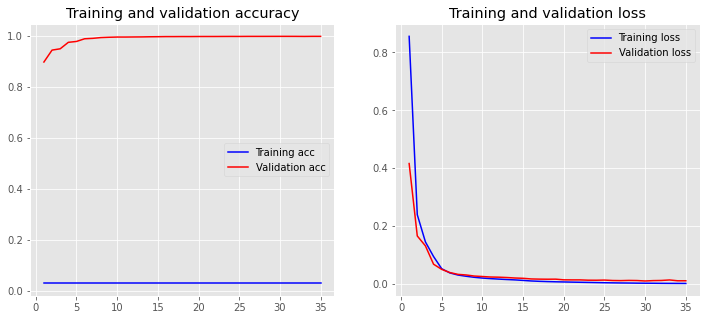

600/600 [==============================] - 13s 22ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.907075873827792,0.7665706051873199,0.8309254197579071,15268.0
Disease,0.5922247225886552,0.6210432093742371,0.6062917063870352,12289.0
micro avg,0.7497479643272587,0.7016728961788293,0.7249142407258141,27557.0
macro avg,0.7496502982082236,0.6938069072807784,0.7186085630724712,27557.0
weighted avg,0.7666685073663575,0.7016728961788293,0.7307503751734223,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_54 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_108 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_54 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_54 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

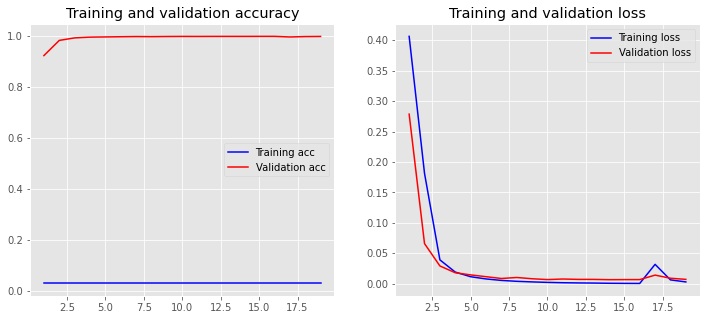

600/600 [==============================] - 14s 23ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9358059914407989,0.8163479172124706,0.8720047574072132,15268.0
Disease,0.5702538151340238,0.5868663031979819,0.5784408084696823,12289.0
micro avg,0.7577601478856967,0.7140109591029502,0.7352353193954001,27557.0
macro avg,0.7530299032874114,0.7016071102052263,0.7252227829384477,27557.0
weighted avg,0.7727885840802751,0.7140109591029502,0.7410903847072343,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_55 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_110 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_55 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_55 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

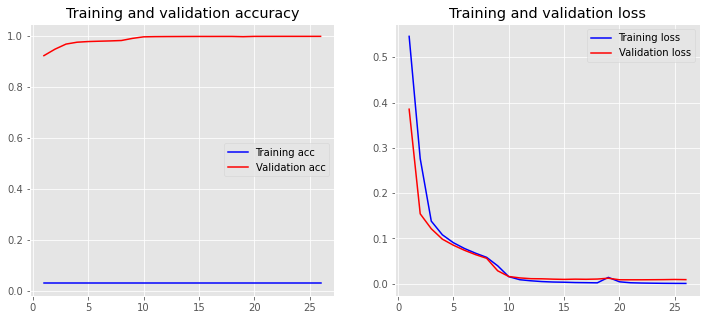

600/600 [==============================] - 14s 23ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8723028205317034,0.7758056064972492,0.8212292439421777,15268.0
Disease,0.519787314849981,0.5568394499145577,0.5376758073387287,12289.0
micro avg,0.6987735566856117,0.6781579997822694,0.688311449144583,27557.0
macro avg,0.6960450676908422,0.6663225282059034,0.6794525256404531,27557.0
weighted avg,0.7150990955499316,0.6781579997822694,0.6947790431794029,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_56 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_112 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_56 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_56 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

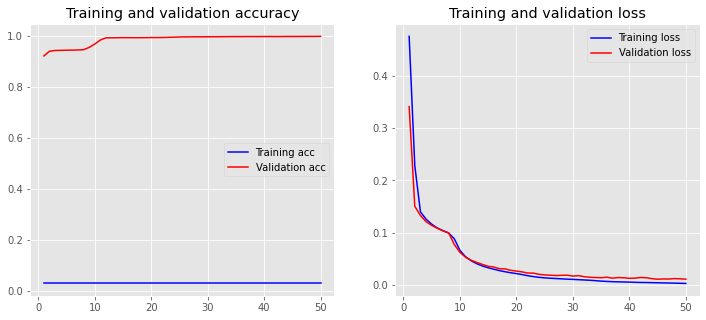

600/600 [==============================] - 14s 23ms/step
F1-score: 67.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7264641819941917,0.7864160335341892,0.7552522329852812,15268.0
Disease,0.5680762852404644,0.5574904386036292,0.5627335824879871,12289.0
micro avg,0.6596474045053868,0.6843270312443299,0.6717606198236709,27557.0
macro avg,0.647270233617328,0.6719532360689092,0.6589929077366341,27557.0
weighted avg,0.6558313531954635,0.6843270312443299,0.6693988492366422,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_57 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_114 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_57 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_57 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

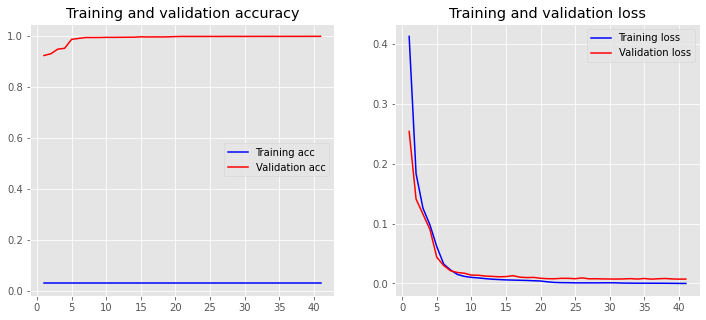

600/600 [==============================] - 14s 23ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9047944166287362,0.7811763164789102,0.8384534270650263,15268.0
Disease,0.5508888888888889,0.6051753600781187,0.5767575322812051,12289.0
micro avg,0.7257327036953751,0.7026889719490511,0.7140249635870867,27557.0
macro avg,0.7278416527588125,0.6931758382785145,0.7076054796731157,27557.0
weighted avg,0.7469708135371447,0.7026889719490511,0.7217505620580089,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_58 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_116 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_58 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_58 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

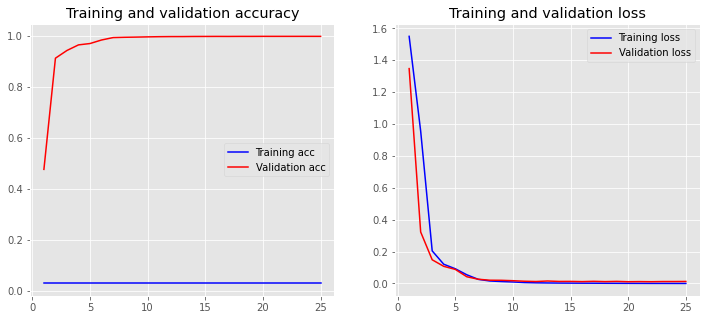

600/600 [==============================] - 14s 23ms/step
F1-score: 66.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8374811463046757,0.7273382237359183,0.7785333707234997,15268.0
Disease,0.4891433867337482,0.6012694279436894,0.5394415039240736,12289.0
micro avg,0.6519777198054009,0.6711180462314476,0.6614094379772186,27557.0
macro avg,0.6633122665192119,0.6643038258398039,0.6589874373237867,27557.0
weighted avg,0.6821404805077048,0.6711180462314476,0.671910735781447,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_59 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_118 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_59 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_59 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

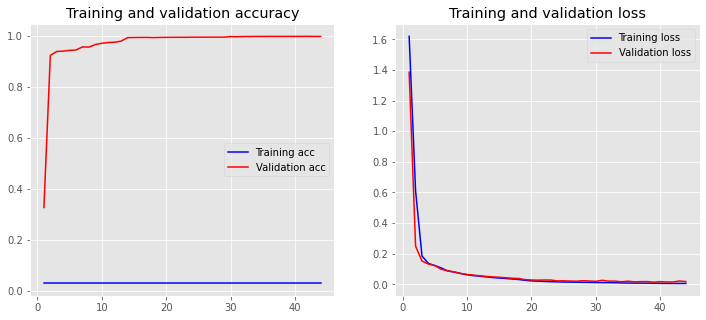

600/600 [==============================] - 14s 24ms/step
F1-score: 65.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.770940170940171,0.7384726224783862,0.7543572073729635,15268.0
Disease,0.556836902800659,0.5225811701521687,0.5391654772899,12289.0
micro avg,0.6765425491245508,0.6421961752004935,0.6589220888020106,27557.0
macro avg,0.663888536870415,0.6305268963152775,0.6467613423314318,27557.0
weighted avg,0.6754611615354295,0.6421961752004935,0.6583928001083568,27557.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 7200
Points in y_train after augmentation: 7200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_60 (Embedding)     (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_120 (CuDNNLSTM)   (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_60 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_60 (CRF)                 (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
________________________________________________

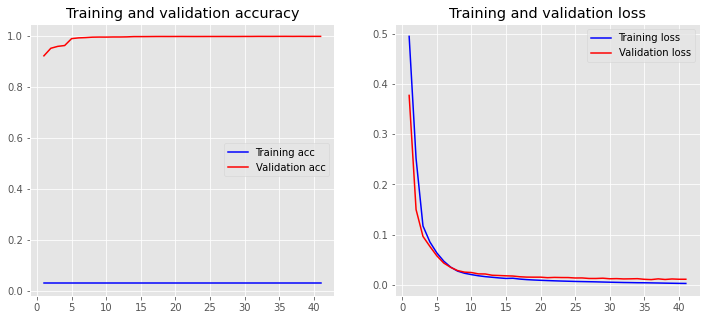

600/600 [==============================] - 14s 24ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8908472012102875,0.7713518470002619,0.8268042684639145,15268.0
Disease,0.5337663353940058,0.555049231019611,0.5441997766076272,12289.0
micro avg,0.7153352052002,0.674892041949414,0.6945253566360445,27557.0
macro avg,0.7123067683021467,0.6632005390099365,0.6855020225357709,27557.0
weighted avg,0.7316075611908266,0.674892041949414,0.7007772480908001,27557.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 1000% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainab

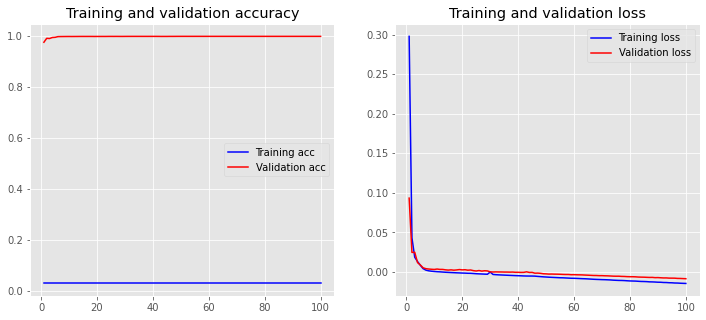

600/600 [==============================] - 5s 8ms/step
F1-score: 68.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8687301470045061,0.7702384071260152,0.816524908869988,15268.0
Disease,0.5032159671109343,0.6175441451704776,0.554548776032152,12289.0
micro avg,0.6761129359144594,0.7021446456435751,0.6888829550511794,27557.0
macro avg,0.6859730570577203,0.6938912761482464,0.6855368424510699,27557.0
weighted avg,0.7057296840835747,0.7021446456435751,0.6996970721517616,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

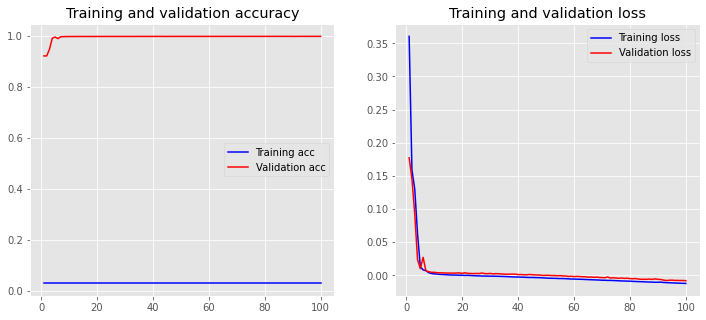

600/600 [==============================] - 5s 8ms/step
F1-score: 70.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8726807888970051,0.7824862457427298,0.8251260446163409,15268.0
Disease,0.5084271449468931,0.6505004475547237,0.5707553905469084,12289.0
micro avg,0.6779655254479312,0.7236273904996916,0.7000526592943656,27557.0
macro avg,0.6905539669219491,0.7164933466487268,0.6979407175816246,27557.0
weighted avg,0.7102424599605125,0.7236273904996916,0.7116898589698897,27557.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

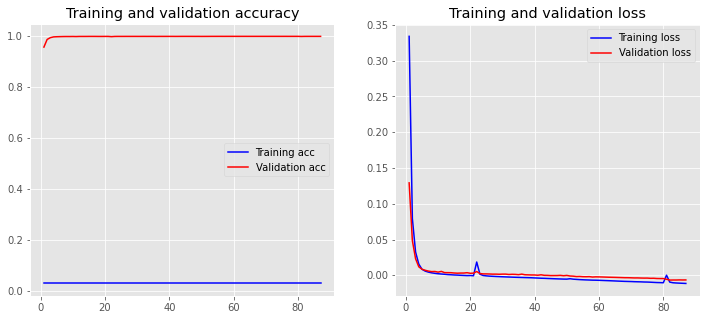

600/600 [==============================] - 5s 9ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8463218714768884,0.7866780193869531,0.8154107264086897,15268.0
Disease,0.5678312647966138,0.6440719342501424,0.6035534543236236,12289.0
micro avg,0.7083288898368348,0.7230830641942156,0.7156299382272663,27557.0
macro avg,0.7070765681367511,0.7153749768185478,0.7094820903661567,27557.0
weighted avg,0.7221294316070225,0.7230830641942156,0.7209333153460421,27557.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

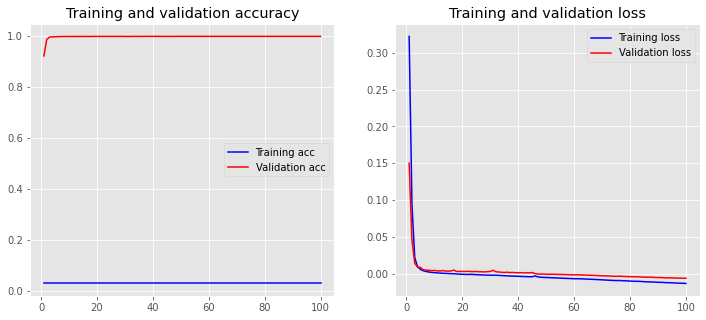

600/600 [==============================] - 5s 9ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8821452715390972,0.7691904637149594,0.8218046954270319,15268.0
Disease,0.5113896004985113,0.6010253071852877,0.5525961394583271,12289.0
micro avg,0.6892203487534226,0.6941974815836267,0.6916999620342414,27557.0
macro avg,0.6967674360188043,0.6851078854501236,0.6872004174426796,27557.0
weighted avg,0.7168073740387249,0.6941974815836267,0.7017515712009038,27557.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

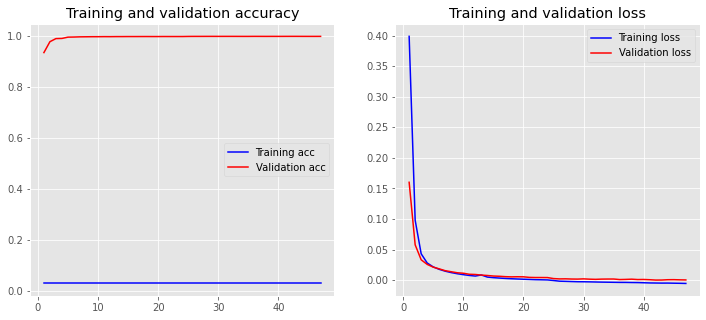

600/600 [==============================] - 6s 9ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.882370480805069,0.7752816347917213,0.8253669420911343,15268.0
Disease,0.5404281533959648,0.5710798274879973,0.5553313550939664,12289.0
micro avg,0.7141774932767698,0.6842181659832347,0.698876904258868,27557.0
macro avg,0.7113993171005168,0.6731807311398593,0.6903491485925504,27557.0
weighted avg,0.7298818477343253,0.6842181659832347,0.7049450047028774,27557.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

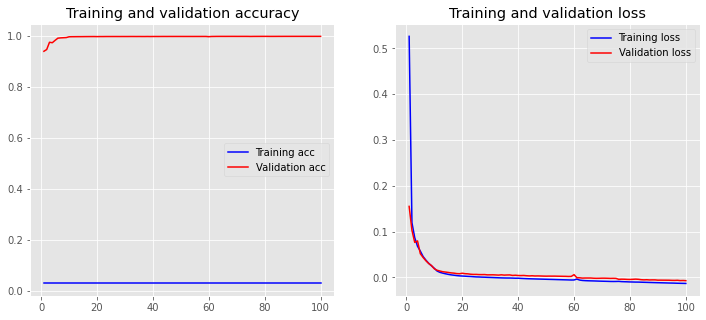

600/600 [==============================] - 6s 9ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8837645024140665,0.803248624574273,0.8415851775604735,15268.0
Disease,0.4760061402923313,0.5803564163072666,0.523027280727486,12289.0
micro avg,0.6720720720720721,0.7038502014007331,0.6875941648793804,27557.0
macro avg,0.6798853213531989,0.6918025204407698,0.6823062291439798,27557.0
weighted avg,0.7019253141093162,0.7038502014007331,0.6995247938401634,27557.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

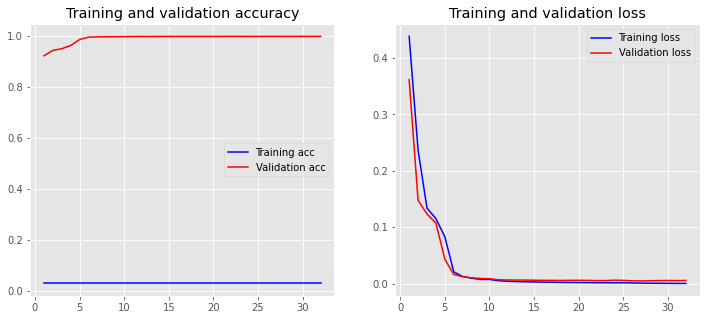

600/600 [==============================] - 6s 10ms/step
F1-score: 69.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8671298922291548,0.8010217448257794,0.8327658994961188,15268.0
Disease,0.5022953598417967,0.5787289445845878,0.5378100423472474,12289.0
micro avg,0.6843576407316987,0.7018906267010198,0.6930132568971695,27557.0
macro avg,0.6847126260354758,0.6898753447051835,0.685287970921683,27557.0
weighted avg,0.7044325170247333,0.7018906267010198,0.7012308075593158,27557.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

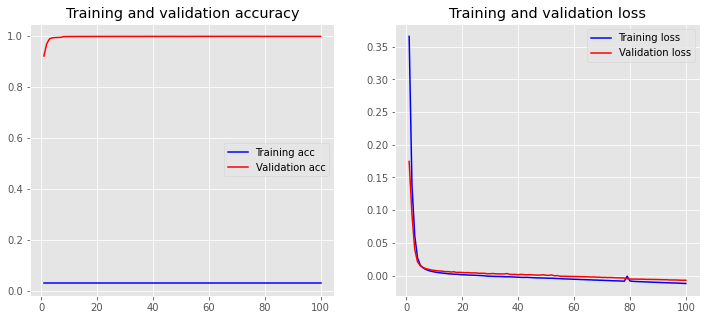

600/600 [==============================] - 6s 10ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8497842317966984,0.8125491223473933,0.830749656811866,15268.0
Disease,0.5609701492537313,0.6116852469688339,0.5852310327377476,12289.0
micro avg,0.7115611271831137,0.7229741989331204,0.7172222622219022,27557.0
macro avg,0.7053771905252149,0.7121171846581136,0.7079903447748068,27557.0
weighted avg,0.720988054405454,0.7229741989331204,0.721261019759689,27557.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 10

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 1000% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainab

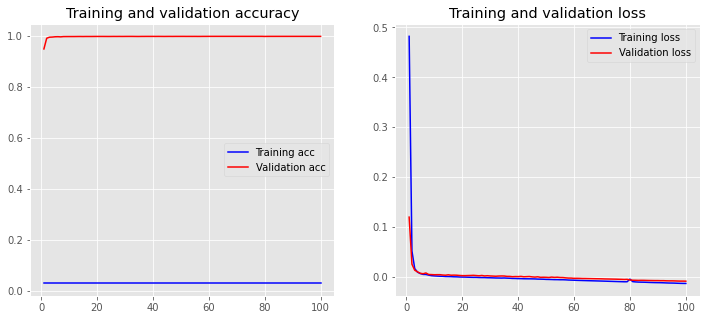

600/600 [==============================] - 5s 8ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.907191883019994,0.7964369924024103,0.8482142857142857,15268.0
Disease,0.5589536016790345,0.6068028318007974,0.5818962153726102,12289.0
micro avg,0.7334828939988783,0.7118699423014117,0.7225148245000185,27557.0
macro avg,0.7330727423495143,0.7016199121016038,0.715055250543448,27557.0
weighted avg,0.7518955793802998,0.7118699423014117,0.7294501689225866,27557.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13200
Points in y_train after augmentation: 13200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2786850   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          362400    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 651, 300)          722400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,873,220
Trainable params: 3,873,220
Non-trainable params: 0
_________________________________________________

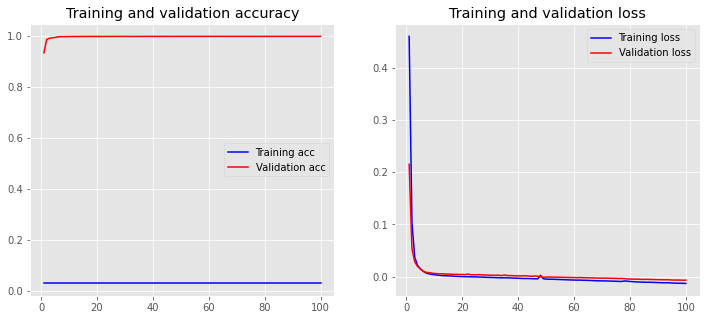

600/600 [==============================] - 5s 8ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8942547876769359,0.7737752161383286,0.8296639629200463,15268.0
Disease,0.5037156704361874,0.6343071039140695,0.5615185131825385,12289.0
micro avg,0.6835738687861674,0.7115796349384911,0.6972956634603417,27557.0
macro avg,0.6989852290565617,0.7040411600261991,0.6955912380512924,27557.0
weighted avg,0.720094494039328,0.7115796349384911,0.7100849292144822,27557.0



In [ ]:
number_of_training_models = 2
target_augmented_percentage = 10

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)